## Tutorial notebook

This Jupyter notebook shows how to perform a basic analysis of γ-ray photon-count maps using the convolutional neural network-based method presented in [arXiv:2107.09070](http://arxiv.org/abs/2107.09070). 

In this example, the photon-count maps consist of **three** different emission components:    
1. *Fermi* bubbles (Poissonian)
2. Galactic Center Excess (point source-like, single population)
3. Isotropic point sources (point source-like, two populations in each map).

As discussed in the paper, for the point source-like templates the Poissonian case is included as the limit of ultra-faint point source emission (<< 1 photon expected per source) where the neural network can no longer distinguish point sources from Poissonian emission.

To consider different scenarios (e.g. other templates, more training data, different network architectures, etc.), simply modify the sample parameter file ```GCE_NN/parameter_files/parameters.py``` accordingly.
The available templates can be viewed in the function ```get_templates()``` in ```GCE/data_utils.py```.

Also, if you don't have access to a GPU and just want to try out the code, it is recommended to reduce the number of training steps in the ```parameters.py```
file in the folder ```parameter_files``` under "Training settings" from ```2500``` to e.g. ```p_train['num_steps'] = 500``` to reduce the
training time. In this case, you will see a warning
```
"WARNING:tensorflow:There are non-GPU devices in `tf.distribute.Strategy`...
```

In [1]:
import ray
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import healpy as hp
import os

In [2]:
%pip list | grep gce-nn   # check if gce-nn module is there
import GCE.gce

You should consider upgrading via the '/home/flo/GCE_NN/venv/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


2022-10-14 16:58:23.349969: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-14 16:58:23.350002: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


First, we need to **initialize** an analysis object.

In [3]:
gce = GCE.gce.Analysis()

2022-10-14 16:58:36.522080: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-14 16:58:36.589516: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-10-14 16:58:36.822722: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:923] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-10-14 16:58:36.822763: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: NVIDIA GeForce GTX 1650 computeCapability: 7.5
coreClock: 1.515GHz coreCount: 14 deviceMemorySize: 4.00GiB deviceMemoryBandwidth: 178.84GiB/s
202

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of devices: 1


Now, let's **load the parameters** from the parameter file in the parameter_files folder.

In [4]:
gce.load_params("../parameter_files/parameters.py")

Loading parameters from '../parameter_files/parameters.py'...
Loading parameters: ['Edep' 'comb' 'data' 'gen' 'mod' 'nn' 'plot' 'train' 'tt']


We can take a look at the loaded parameters:

The parameters are stored in gce.p and can also be accessed group-wise. For example, the Poissonian (P) and point-source (PS) templates used in this analysis can be viewed with

and the data-related settings (such as the exposure map, the mask for the region of interest, as well as whether the *Fermi* point-spread function at 2 GeV shall be applied) are stored in

Now, let's generate some simulated Monte Carlo photon-count maps for each of the templates. The relevant parameters are stored in the field "tt" (training and testing data) - most importantly the priors, as well as the number of maps given by "n_chunk" (each chunk will be saved in a single file) times the number of simulations per chunk.

To **generate** the template maps, we can simply run

FileNotFoundError: [Errno 2] No such file or directory: '/home/flo/GCE_NN/data/Template_maps/Example_256/iso_PS/Maps_0_3.pickle'

Some example maps (whose number is determined by ```n_example_plots``` above) for each template can be viewed in the folder ```GCE_NN/data/Template_maps/Example_128```.

The next step is to **combine** (i.e. sum up) the individual template maps to obtain the final training, validation, and testing maps. Internally, this is done in two steps: 1) the filenames of the template maps for each of these three subsets are stored in a file, and 2) the template maps are combined and saved.

FileNotFoundError: [Errno 2] No such file or directory: '/home/flo/GCE_NN/data/Combined_maps/Example_comb_256/Train/Maps_07_train.pickle'

NOTE: if data has already been generated, the corresponding parameters can be directly loaded from the template maps / combined maps folders, e.g.

```
gce.load_params("../data/Template_maps/Test_128")
gce.load_params("../data/Combined_maps/Test_comb_128")
```


Next, we need to build the **data processing pipeline** that will feed the combined photon-count maps to the neural network.

In [ ]:
gce.build_pipeline()

We can use the method ```get_samples()``` to get photon-count maps and their associated labels from the datasets **train** (used for training), **val** (used as an independent validation dataset during training), and **test** (used for testing once the training is finished) 

In [ ]:

samples = gce.datasets["test"].get_samples(1)
data, labels = samples["data"], samples["label"]  # samples contains data and labels (flux fractions & SCD histograms)
print("Shapes:")
print("  Flux fractions", labels[0].shape)  # n_samples x n_templates
#print("  SCD histograms", labels[1].shape)  # n_samples x n_bins x n_PS_templates

Let's take a look at a combined map. The maps are compressed and only contain the pixels that lie within the ROI - the method ```decompress()``` returns the full-sky map that can be fed to the healpy functions.

We will plot 
1. the **photon-count map**, 
2. the rescaled version in **'flux' space** as shown to the neural network (divided by exposure correction), and 
3. the *Fermi* **exposure correction**.

In [ ]:
samples = gce.datasets["test"].get_samples(1)
data, labels = samples["data"], samples["label"]
# NOTE: the maps are stored in NEST format
map_to_plot = 0 #index of which map is plotted
r = gce.p.data["outer_rad"] + 1
fig, ax= plt.subplots(2,7,figsize = (25,5))

subplot=1
[axi.set_axis_off() for axi in ax.ravel()]
plt.tight_layout()
for Ebin in range(0,len(gce.p.data["Ebins"])-1):

    hp.cartview(gce.decompress(data[map_to_plot,:,Ebin] * gce.template_dict["rescale_compressed"]), nest=True,
                 lonra=[-r, r], latra=[-r, r], sub=(2,7,subplot), title='Counts Bin ' + str(Ebin))

    hp.cartview(gce.decompress(data[map_to_plot,:,Ebin]), nest=True,
                 lonra=[-r, r], latra=[-r, r], sub=(2,7,7+subplot), title='Flux Bin ' + str(Ebin))
    subplot+=1

plt.show()


hp.cartview(gce.decompress(gce.template_dict["rescale_compressed"], fill_value=np.nan), nest=True,
                title="Fermi exposure correction", lonra=[-r, r], latra=[-r, r])
plt.show()


Let's also plot the real *Fermi* map in our region of interest. Of course, it looks quite different from our simulated maps because we only included the *Fermi* bubbles, the GCE, and isotropic point sources in this example (so we are completely ignoring the diffuse Galactic foregrounds, which are responsible for the majority of photon counts).

In [ ]:
fermi_counts = gce.datasets["test"].get_fermi_counts()
hp.cartview(gce.decompress(fermi_counts * gce.generators["test"].settings_dict["rescale_compressed"]), nest=True,
            title="Fermi data: Count space", max=100, lonra=[-r, r], latra=[-r, r])
# hp.cartview(gce.decompress(fermi_counts), nest=True, title="Fermi data: Flux space", max=100)
plt.show()

Now, it's time to **build** our neural network:


In [7]:
n_samples = 20
test_samples = gce.datasets["test"].get_samples(n_samples)
test_data, test_ffs, test_hists = test_samples["data"], test_samples["label"][0], test_samples["label"][0]
#tau = np.arange(5, 100, 5) * 0.01  # quantile levels for SCD histograms, from 5% to 95% in steps of 5%
#pred = gce.predict(test_data, tau=tau, multiple_taus=True)  # get the NN predictions

KeyError: 'test'

*NOTE*: Once the neural network has been trained, **loading** is as easy as ```gce.load_nn()```.

In [21]:
gce.load_nn()

Checkpoint ../models/checkpoints/Example_comb_128/Training_1/ff/ckpt-500 successfully loaded.


    Let's **train** our neural network to predict
1. the **flux fractions** of the different templates (using a negative maximum log-likelihood loss function), and 
2. the **SCD histograms** of the GCE and isotropic point source populations (using the *Earth Mover's pinball loss*, see [arXiv:2106.02051](https://arxiv.org/abs/2106.02051)).

In [22]:
#gce.train_nn("flux_fractions")

In [23]:
#gce.train_nn("histograms")

Finally, let's **evaluate** the performance of our neural network on simulated test data.

/home/flo/GCE_NN/GCE/gce.py:885: UserWarning: A value of tau has been provided; however, SCD histogram estimation with the EMPL is disabled. The values of tau will be ignored.
  warnings.warn("A value of tau has been provided; however, SCD histogram estimation with the EMPL is "
/home/flo/GCE_NN/GCE/gce.py:888: UserWarning: SCD histogram estimation with the EMPL is disabled, 'multiple_taus' will be ignored.
  warnings.warn("SCD histogram estimation with the EMPL is disabled, 'multiple_taus' will be ignored.")


In [25]:
pred['ff_mean'].shape

TensorShape([20, 2, 2])

In [26]:
print(test_ffs.shape)
test_ffs[0]

(20, 2, 2)


array([[1.        , 0.15198368],
       [0.        , 0.8480163 ]], dtype=float32)

In [27]:
true_ffs = np.average(test_ffs, axis=2)
true_ffs

array([[0.57599187, 0.42400816],
       [0.6116016 , 0.38839844],
       [0.5296667 , 0.47033325],
       [0.559872  , 0.44012803],
       [0.54311025, 0.45688975],
       [0.52383274, 0.47616726],
       [0.5201902 , 0.47980985],
       [0.53891736, 0.46108264],
       [0.5       , 0.5       ],
       [0.5250662 , 0.4749338 ],
       [0.5768281 , 0.42317188],
       [0.5801249 , 0.4198751 ],
       [0.5754365 , 0.42456353],
       [0.6481585 , 0.35184154],
       [0.53154117, 0.46845883],
       [0.56169844, 0.43830156],
       [0.60459304, 0.39540693],
       [0.55883944, 0.4411606 ],
       [0.5437692 , 0.45623082],
       [0.5730219 , 0.4269781 ]], dtype=float32)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


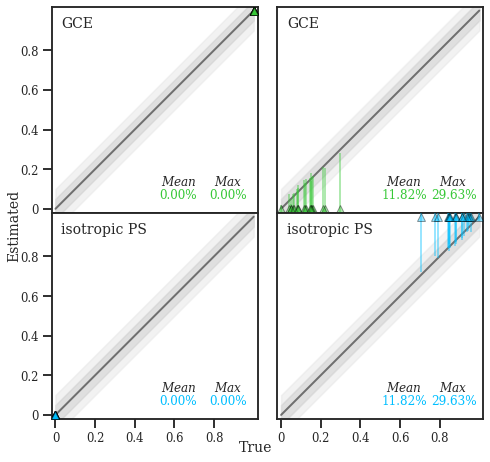

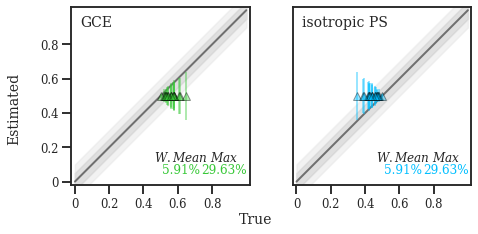

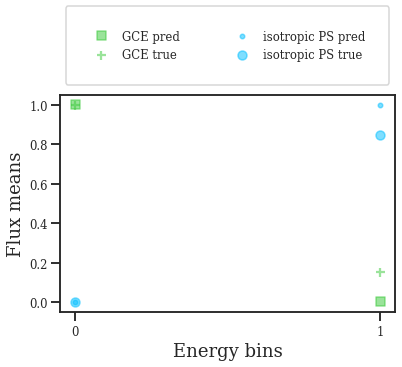

AssertionError: Shape of maps must be n_maps x n_pixels.

In [28]:
gce.plot_nn_architecture()
gce.plot_flux_fractions_Ebin(test_ffs, pred)
gce.plot_flux_fractions_total(test_ffs, pred)
gce.plot_flux_per_Ebin(test_ffs, pred)
#gce.plot_histograms(test_hists, pred, plot_inds=np.arange(9))
gce.plot_maps(test_data, decompress=True, plot_inds=np.arange(9))
plt.show()